# Explainability of Neural Network Models for Time Series

## Notebook Overview
The aim is to identify and quantify the most relevant input features influencing model performance.

## Imports

In [1]:
import pandas as pd
import numpy as np
import sys

import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderRefined as ae
from dl_models import LSTMBasic as lstm
from dl_models import AutoencoderLSTM as ael
from utils import plots as plts
from utils import importance as im

In [2]:
# Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']


df1 = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)
# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

X_train = df1
X_test = pd.concat([building_2_3_data, external_data_repeated], axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train[features].values)
X_test_scaled = scaler.transform(X_test[features].values)

In [3]:
def create_lstm_input(data, timesteps):
    X_seq = []
    for i in range(len(data) - timesteps + 1):
        X_seq.append(data[i:i+timesteps])
    return np.array(X_seq)

def create_lstm_input_with_target(data, timesteps):
    X_seq, y = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X_seq), np.array(y)

## Phase 1: Identifying Important Features
- Use the best pre-trained models from the evaluation notebooks to test on the full feature set. For LSTM and Autoencoder-LSTM models, input data is first reshaped into sequences of fixed length (timesteps). 
- Compute permutation feature importance by measuring the increase in prediction/reconstruction error when permuting each feature.  
- Visualize feature importance using horizontal bar plots, with mean and standard deviation of error increases, normalized relative to the maximum value to allow easy comparison of the relative contribution of each feature.


In [4]:
model = load_model("..\\reports\\models\\autoencoder_generalization.h5")
means_ae, stds_ae = im.importance_autoencoder(model, X_test_scaled, features)
sorted_idx_ae = np.argsort(means_ae)

45/45 [==============================] - 0s 1ms/step


In [5]:
model = load_model("..\\reports\\models\\lstm_generalization.h5")
timesteps = 3
X_test_seq = create_lstm_input(X_test_scaled, timesteps=timesteps)
y_true = X_test_scaled[timesteps-1:, :]
means_lstm, stds_lstm = im.importance_lstm(model, X_test_seq, y_true, features)
sorted_idx_lstm = np.argsort(means_lstm)

45/45 [==============================] - 0s 2ms/step


In [6]:
model = load_model("..\\reports\\models\\autoencoderLSTM_generalization.h5")
timesteps = 6
X_test_seq = create_lstm_input(X_test_scaled, timesteps=timesteps)
means_aelstm, stds_aelstm = im.importance_autoencoder_lstm(model, X_test_seq, features)
sorted_idx_aelstm = np.argsort(means_aelstm)

45/45 [==============================] - 0s 6ms/step


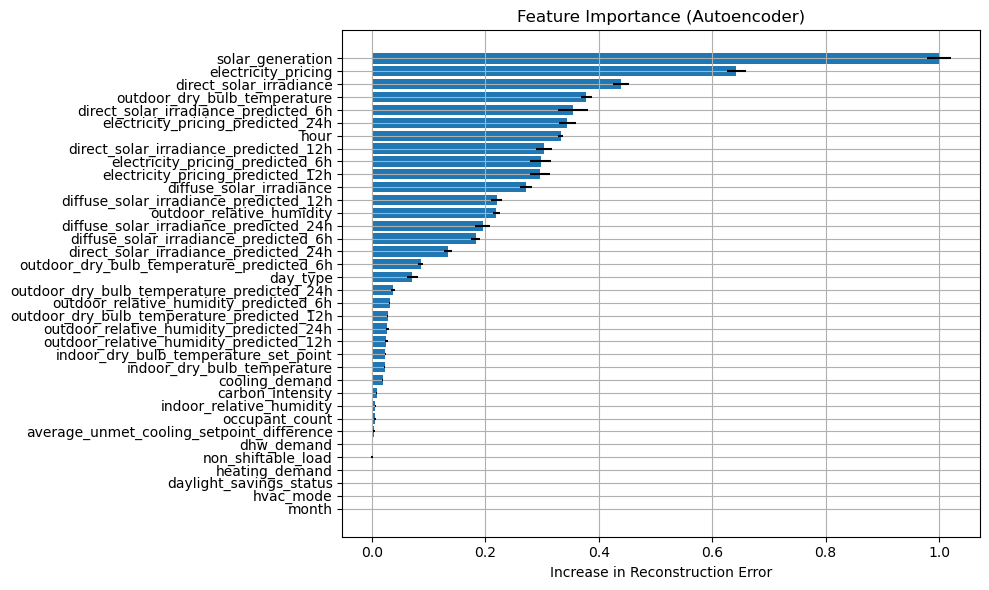

In [7]:
plts.plot_feature_importance(features, means_ae, stds_ae, title="Feature Importance (Autoencoder)")

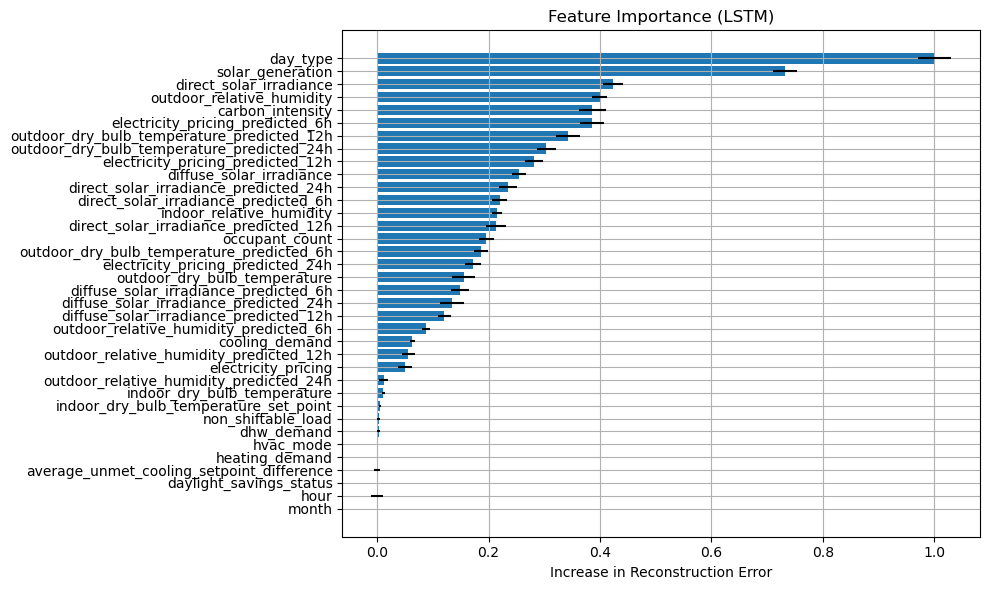

In [8]:
plts.plot_feature_importance(features, means_lstm, stds_lstm, title="Feature Importance (LSTM)")

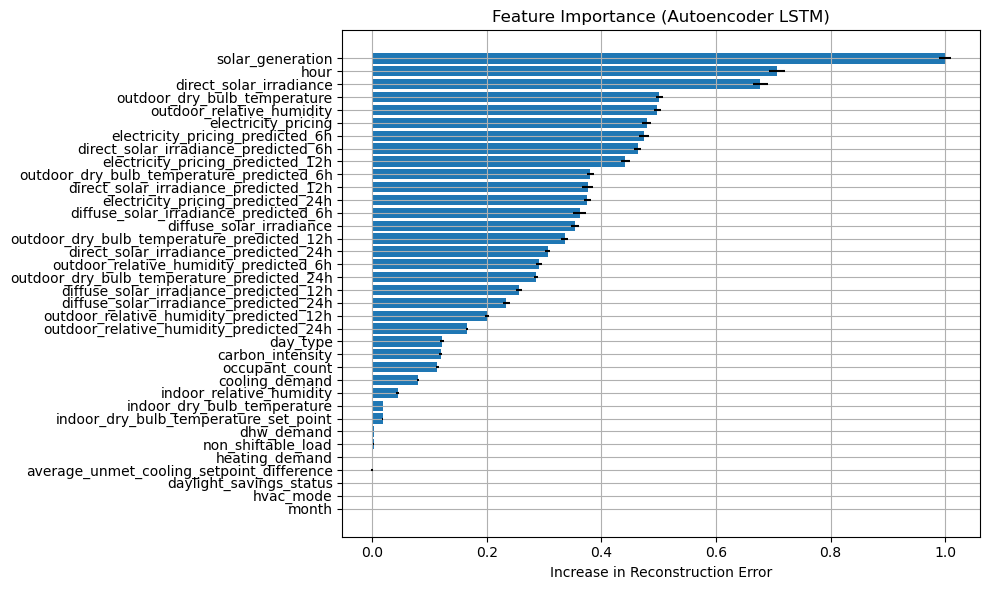

In [9]:
plts.plot_feature_importance(features, means_aelstm, stds_aelstm, title="Feature Importance (Autoencoder LSTM)")

## Phase 2: Training on Relevant Features
- Select features whose importance scores fall within the third and fourth quartiles, adding required target features if missing.  
- Prepare reduced datasets containing only these selected features.  
- Retrain models on the reduced datasets.  
- Compare prediction results with those obtained using the full feature set (see the generalization notebook).

In [10]:
q3 = np.percentile(means_ae, 75)
selected_features_ae = [f for f, m in zip(features, means_ae) if m >= q3]

for t in targets:
    if t not in selected_features_ae:
        selected_features_ae.append(t)

X_train_relevant_ae = X_train[selected_features_ae].copy()
X_test_relevant_ae = X_test[selected_features_ae].copy()

In [11]:
q3 = np.percentile(means_lstm, 75)
selected_features_lstm = [f for f, m in zip(features, means_lstm) if m >= q3]

for t in targets:
    if t not in selected_features_lstm:
        selected_features_lstm.append(t)

X_train_relevant_lstm = X_train[selected_features_lstm].copy()
X_test_relevant_lstm = X_test[selected_features_lstm].copy()

In [12]:
q3 = np.percentile(means_aelstm, 75)
selected_features_ael = [f for f, m in zip(features, means_aelstm) if m >= q3]

for t in targets:
    if t not in selected_features_ael:
        selected_features_ael.append(t)

X_train_relevant_ael = X_train[selected_features_ael].copy()
X_test_relevant_ael = X_test[selected_features_ael].copy()

In [13]:
real_ae, pred_ae, model_ae = ae.Autoencoder(train_df=X_train_relevant_ae, test_df=X_test_relevant_ae, features=selected_features_ae, epochs = 600, latent_dim = 128, batch_size = 32)

Epoch 1/600
23/23 [==============================] - 1s 5ms/step - loss: 0.1155 - mean_absolute_error: 0.3052
Epoch 2/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0673 - mean_absolute_error: 0.2123
Epoch 3/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0390 - mean_absolute_error: 0.1576
Epoch 4/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0237 - mean_absolute_error: 0.1179
Epoch 5/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0176 - mean_absolute_error: 0.0978
Epoch 6/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0867
Epoch 7/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0121 - mean_absolute_error: 0.0783
Epoch 8/600
23/23 [==============================] - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0711
Epoch 9/600
23/23 [==============================] - 0s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0644
Epoch 10/6

In [14]:
real_lstm, real_lstm, pred_lstm, model_lstm = lstm.lstm_forecast(train_df=X_train_relevant_lstm, test_df=X_test_relevant_lstm, features=selected_features_lstm, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)

Epoch 1/150
45/45 - 2s - loss: 0.0606 - 2s/epoch - 36ms/step
Epoch 2/150
45/45 - 0s - loss: 0.0240 - 179ms/epoch - 4ms/step
Epoch 3/150
45/45 - 0s - loss: 0.0159 - 174ms/epoch - 4ms/step
Epoch 4/150
45/45 - 0s - loss: 0.0129 - 173ms/epoch - 4ms/step
Epoch 5/150
45/45 - 0s - loss: 0.0120 - 186ms/epoch - 4ms/step
Epoch 6/150
45/45 - 0s - loss: 0.0104 - 161ms/epoch - 4ms/step
Epoch 7/150
45/45 - 0s - loss: 0.0100 - 152ms/epoch - 3ms/step
Epoch 8/150
45/45 - 0s - loss: 0.0091 - 153ms/epoch - 3ms/step
Epoch 9/150
45/45 - 0s - loss: 0.0088 - 169ms/epoch - 4ms/step
Epoch 10/150
45/45 - 0s - loss: 0.0086 - 154ms/epoch - 3ms/step
Epoch 11/150
45/45 - 0s - loss: 0.0082 - 148ms/epoch - 3ms/step
Epoch 12/150
45/45 - 0s - loss: 0.0079 - 151ms/epoch - 3ms/step
Epoch 13/150
45/45 - 0s - loss: 0.0078 - 153ms/epoch - 3ms/step
Epoch 14/150
45/45 - 0s - loss: 0.0078 - 151ms/epoch - 3ms/step
Epoch 15/150
45/45 - 0s - loss: 0.0074 - 149ms/epoch - 3ms/step
Epoch 16/150
45/45 - 0s - loss: 0.0073 - 144ms/epoc

In [15]:
real_ael, pred_ael, model_ael = ael.Autoencoder(train_df=X_train_relevant_ael, test_df=X_test_relevant_ael, features=selected_features_ael, epochs = 150, batch_size = 64, latent_dim = 256, timesteps = 6)

Epoch 1/150
12/12 [==============================] - 2s 36ms/step - loss: 0.1386
Epoch 2/150
12/12 [==============================] - 0s 32ms/step - loss: 0.0735
Epoch 3/150
12/12 [==============================] - 0s 30ms/step - loss: 0.0499
Epoch 4/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0377
Epoch 5/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0304
Epoch 6/150
12/12 [==============================] - 0s 29ms/step - loss: 0.0254
Epoch 7/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0225
Epoch 8/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0206
Epoch 9/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0190
Epoch 10/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0175
Epoch 11/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0160
Epoch 12/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0149
Epoch 13/150
12/12 [=====

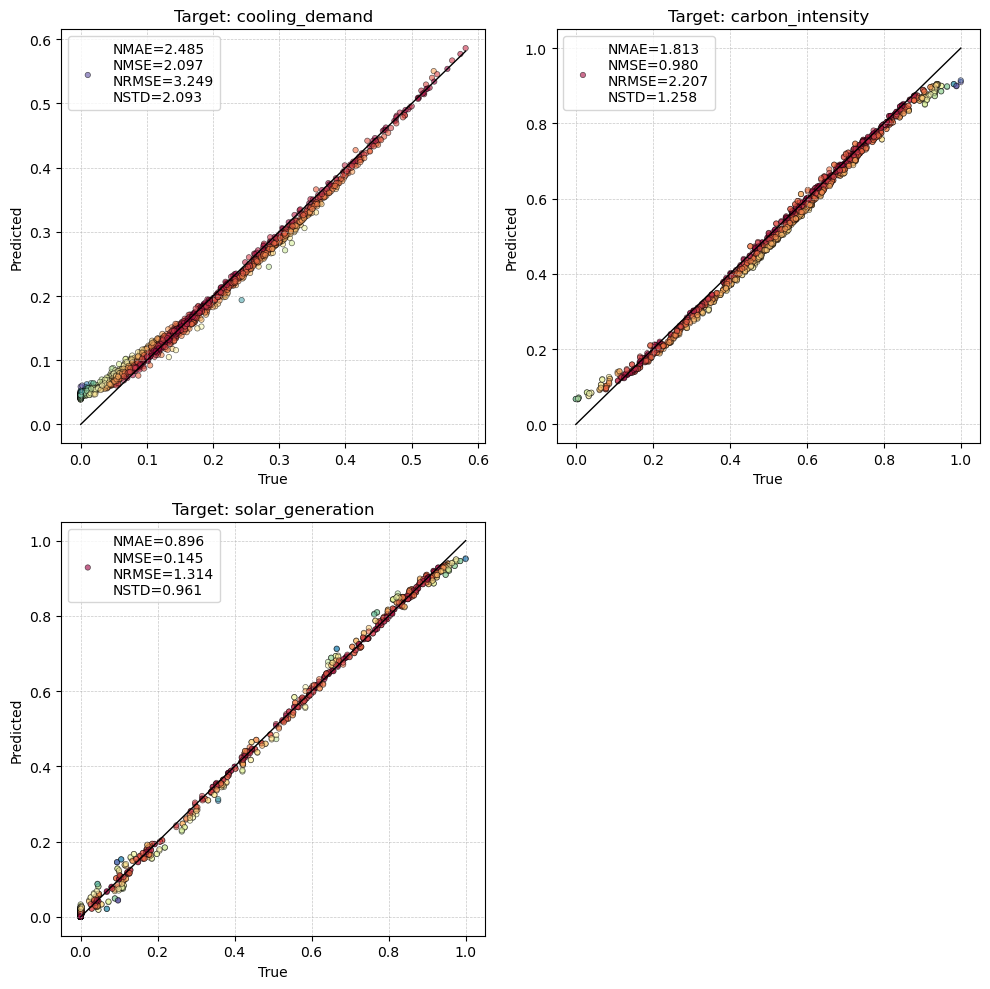

In [16]:
plts.plot_targets(real_ae, pred_ae, targets, selected_features_ae, percent=True)

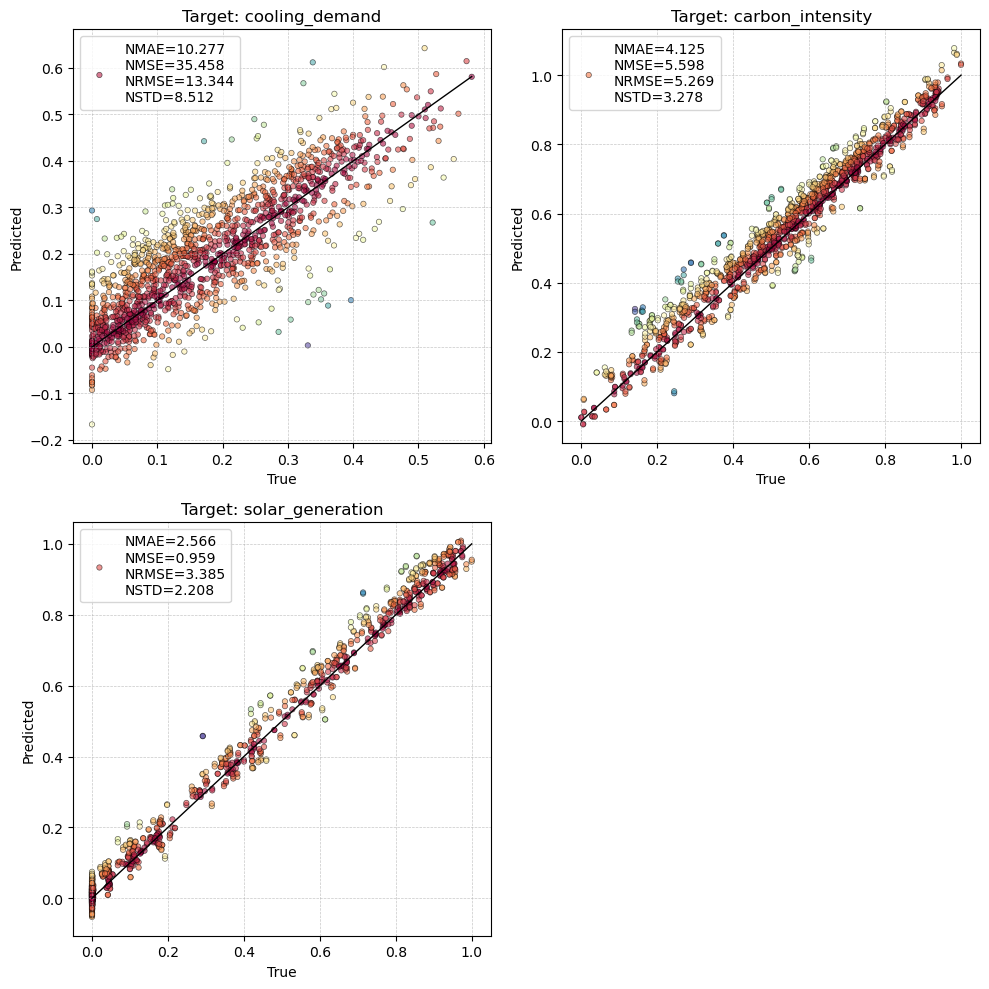

In [17]:
plts.plot_targets(real_lstm, pred_lstm, targets, selected_features_lstm, percent=True)

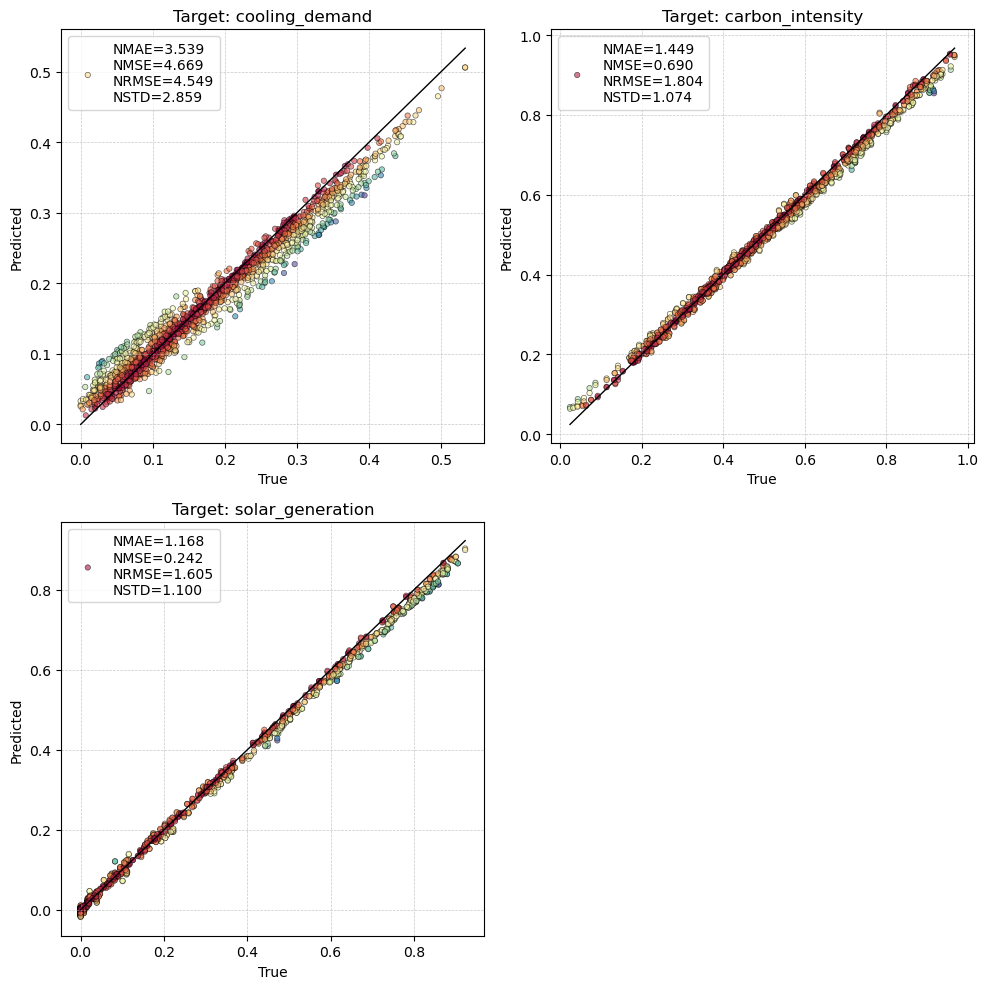

In [18]:
plts.plot_aelstm_targets(real_ael, pred_ael, targets, selected_features_ael, percent=True)

## Extra: Recursive Feature Elimination with Cross Validation (RFECV)

RFECV will be applied as an additional feature selection method.  
A baseline model (e.g., Random Forest Regressor) is used to iteratively remove the least important features, while cross validation evaluates model performance at each step.  

**Outputs**  
- Optimal number of features.  
- Selected feature subset.  
- Performance curve vs. number of features.

**Integration**  
The selected features will be used to build reduced datasets and retrain the main models, enabling performance comparison with the full feature set.

In [19]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
cv = TimeSeriesSplit(n_splits=5)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error", 
    n_jobs=-1
)

X_train_ = X_train.drop(columns=targets)
y_train_ = X_train[targets] 

In [20]:
rfecv.fit(X_train_, y_train_)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
      scoring='neg_mean_squared_error')

In [22]:
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(X_train_.columns[rfecv.support_]))

Optimal number of features: 7
Selected features: ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_12h']


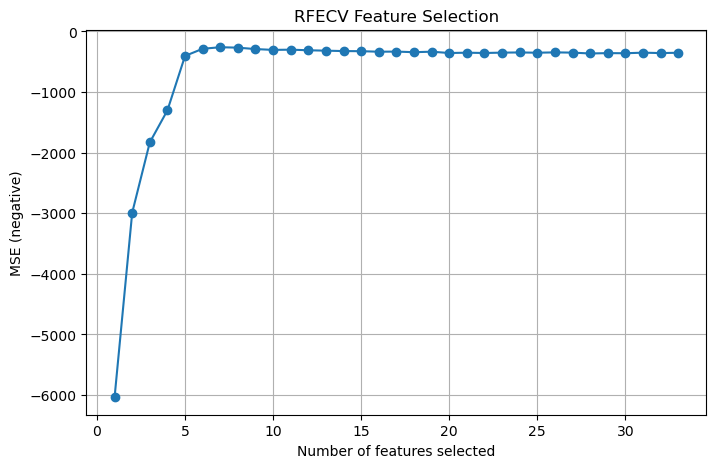

In [23]:
plts.plot_rfecv(rfecv) # RFECV expects higher scores to be better, so we use negative MSE.

In [44]:
selected_features_rfecv = list(X_train_.columns[rfecv.support_])
for t in targets:
    if t not in selected_features_rfecv:
        selected_features_rfecv.append(t)
X_train_rfecv = X_train.loc[:, selected_features_rfecv].copy()
X_test_rfecv = X_test.loc[:, selected_features_rfecv].copy()

In [45]:
real_ae_rfecv, pred_ae_rfecv, model_ae = ae.Autoencoder(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 600, latent_dim = 128, batch_size = 32)

Epoch 1/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0805 - mean_absolute_error: 0.2479
Epoch 2/600
23/23 [==============================] - 0s 3ms/step - loss: 0.0340 - mean_absolute_error: 0.1539
Epoch 3/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0228 - mean_absolute_error: 0.1162
Epoch 4/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0163 - mean_absolute_error: 0.0966
Epoch 5/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0116 - mean_absolute_error: 0.0812
Epoch 6/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0092 - mean_absolute_error: 0.0724
Epoch 7/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0656
Epoch 8/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0612
Epoch 9/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0568
Epoch 10/6

In [46]:
real_lstm_rfecv, real_lstm_rfecv, pred_lstm_rfecv, model_lstm_rfecv = lstm.lstm_forecast(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)

Epoch 1/150
45/45 - 1s - loss: 0.0516 - 1s/epoch - 27ms/step
Epoch 2/150
45/45 - 0s - loss: 0.0189 - 160ms/epoch - 4ms/step
Epoch 3/150
45/45 - 0s - loss: 0.0140 - 153ms/epoch - 3ms/step
Epoch 4/150
45/45 - 0s - loss: 0.0122 - 146ms/epoch - 3ms/step
Epoch 5/150
45/45 - 0s - loss: 0.0105 - 143ms/epoch - 3ms/step
Epoch 6/150
45/45 - 0s - loss: 0.0098 - 145ms/epoch - 3ms/step
Epoch 7/150
45/45 - 0s - loss: 0.0091 - 145ms/epoch - 3ms/step
Epoch 8/150
45/45 - 0s - loss: 0.0088 - 148ms/epoch - 3ms/step
Epoch 9/150
45/45 - 0s - loss: 0.0085 - 145ms/epoch - 3ms/step
Epoch 10/150
45/45 - 0s - loss: 0.0083 - 146ms/epoch - 3ms/step
Epoch 11/150
45/45 - 0s - loss: 0.0081 - 143ms/epoch - 3ms/step
Epoch 12/150
45/45 - 0s - loss: 0.0080 - 146ms/epoch - 3ms/step
Epoch 13/150
45/45 - 0s - loss: 0.0079 - 147ms/epoch - 3ms/step
Epoch 14/150
45/45 - 0s - loss: 0.0076 - 143ms/epoch - 3ms/step
Epoch 15/150
45/45 - 0s - loss: 0.0076 - 147ms/epoch - 3ms/step
Epoch 16/150
45/45 - 0s - loss: 0.0073 - 151ms/epoc

In [47]:
real_ael_rfecv, pred_ael_rfecv, model_ael_rfecv = ael.Autoencoder(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 150, batch_size = 64, latent_dim = 256, timesteps = 6)

Epoch 1/150
12/12 [==============================] - 2s 33ms/step - loss: 0.1406
Epoch 2/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0680
Epoch 3/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0425
Epoch 4/150
12/12 [==============================] - 0s 29ms/step - loss: 0.0287
Epoch 5/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0214
Epoch 6/150
12/12 [==============================] - 0s 29ms/step - loss: 0.0165
Epoch 7/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0132
Epoch 8/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0110
Epoch 9/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0096
Epoch 10/150
12/12 [==============================] - 0s 32ms/step - loss: 0.0088
Epoch 11/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0081
Epoch 12/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0077
Epoch 13/150
12/12 [=====

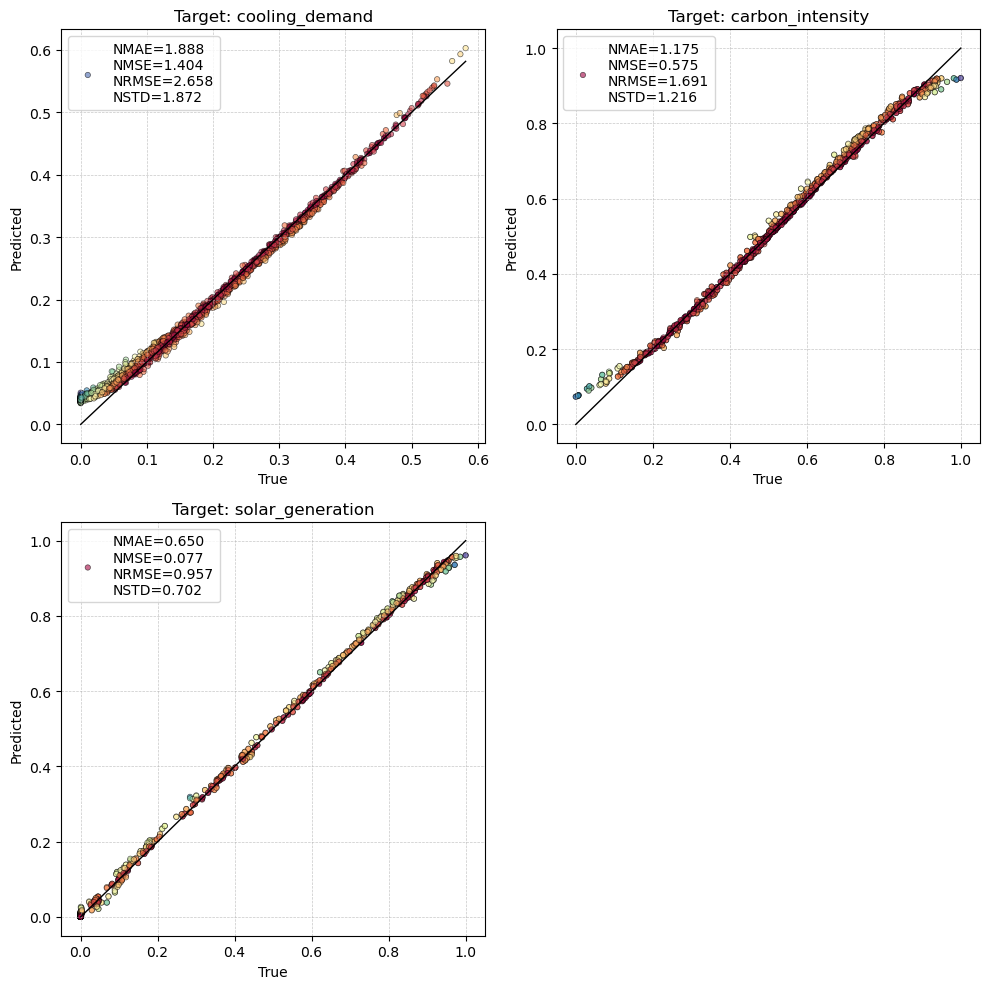

In [48]:
plts.plot_targets(real_ae_rfecv, pred_ae_rfecv, targets, list(selected_features_rfecv), percent=True)

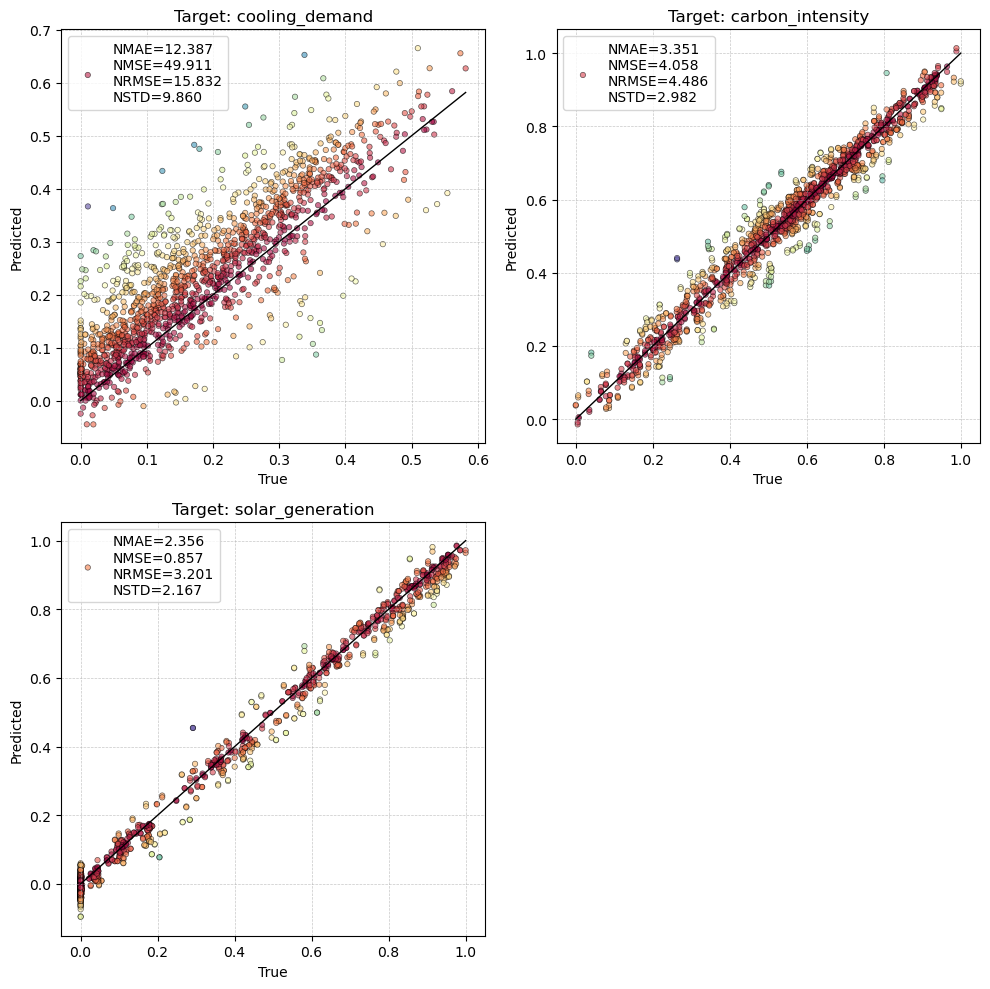

In [49]:
plts.plot_targets(real_lstm_rfecv, pred_lstm_rfecv, targets, selected_features_rfecv, percent=True)

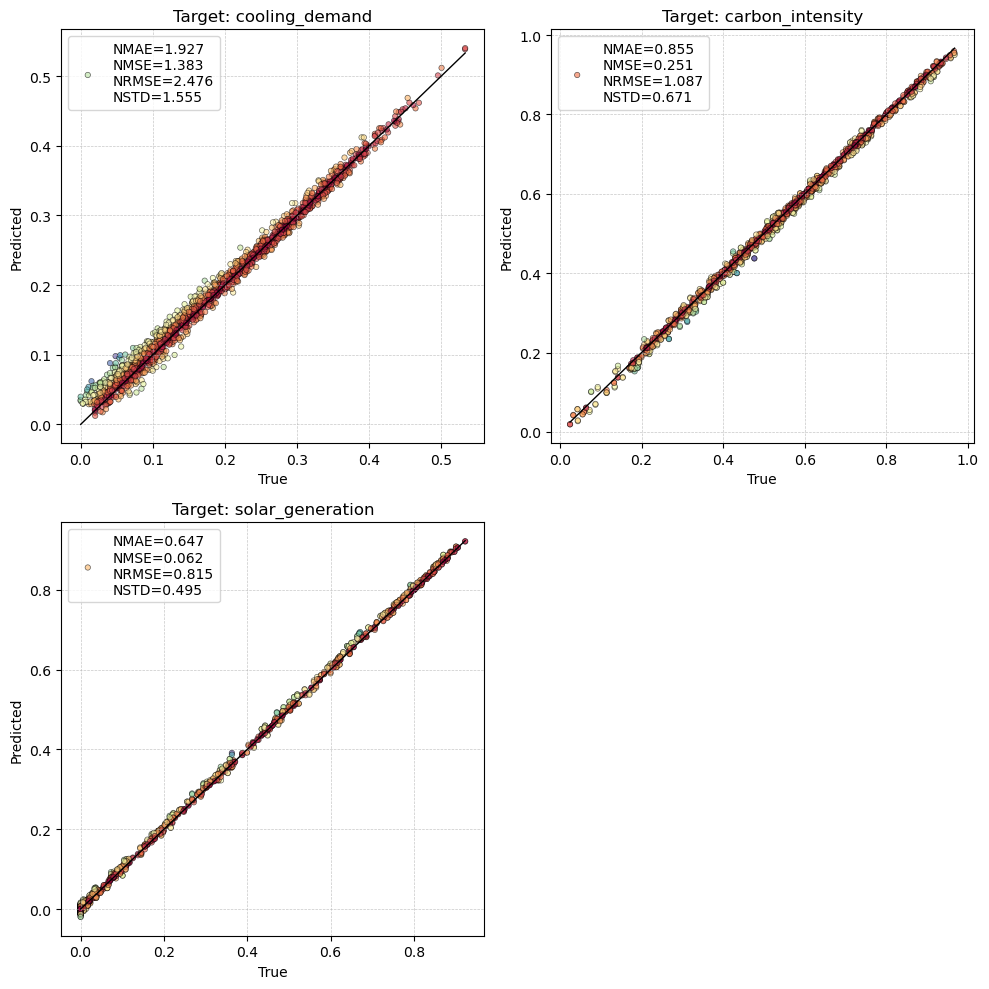

In [50]:
plts.plot_aelstm_targets(real_ael_rfecv, pred_ael_rfecv, targets, selected_features_rfecv, percent=True)